In [4]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# from mpl-toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import fnmatch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
import re
import pickle
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
# CIAO Imports
# CUSTOM Imports
# from data_extraction_functions import *
# from data_exploration_functions import *
# from data_representation_functions import *
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Desktop/Paper/'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

In [9]:
# Select Input
files = os.listdir(f'{global_path}')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*nE16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist3D-nE16-nt24-ndt16-normnone-OBSREGID.pkl', 'hist3D-nE16-nt24…

In [10]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
# features[np.isnan(features)] = 0.0

# Load properties
df_properties_input = pd.read_csv(f'{global_path}/properties-input-sn5.csv')
df_properties = df_properties_input
# df_properties = df_properties_input[df_properties_input['ID'].isin(list(ids))]
# df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))
df_properties.head()

Number of Features:  95366
Number of Property Sets:  151967


,name,obsreg_id,ra,dec,obsid,region_id,gti_obs,gti_end,theta,flux_significance_b,...,var_prob_h,var_prob_m,var_prob_s,var_index_b,var_index_h,var_index_m,var_index_s,livetime,detector,ID
0,2CXO J095546.1+694026,10025-72,148.942369,69.673974,10025,72,2009-04-17T11:58:49,2009-04-17T17:18:30,3.341013,6.531613,...,0.252282,0.650681,0.283007,0.0,0.0,1.0,0.0,17396.334896,ACIS-7,10025-72-1
1,2CXO J095547.4+694059,10025-74,148.947734,69.683258,10025,74,2009-04-17T11:58:49,2009-04-17T17:18:30,3.867397,6.628191,...,0.650170,NaN,NaN,NaN,1.0,NaN,NaN,17396.334896,ACIS-7,10025-74-1
2,2CXO J095550.7+694043,10025-88,148.961137,69.678800,10025,88,2009-04-17T11:58:49,2009-04-17T17:18:30,3.803238,7.755587,...,0.087038,0.048526,NaN,0.0,0.0,0.0,NaN,17396.334896,ACIS-7,10025-88-1
3,2CXO J095546.1+694026,10026-72,148.942369,69.673974,10026,72,2009-04-29T07:34:22,2009-04-29T12:45:42,3.358859,7.362804,...,0.289265,0.587968,0.113789,0.0,0.0,1.0,0.0,16941.772979,ACIS-7,10026-72-1
4,2CXO J095547.4+694059,10026-74,148.947734,69.683258,10026,74,2009-04-29T07:34:22,2009-04-29T12:45:42,3.912211,5.826507,...,0.207648,0.623107,NaN,0.0,0.0,1.0,NaN,16941.772979,ACIS-7,10026-74-1


PCA Plot

In [5]:
# PCA
npca = 100 #36
pca = PCA(npca)
Xpca = pca.fit_transform(features) 
# Compute the size of the eigenvalues and the cumulative relative variance
eigenvalues = pca.explained_variance_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100

Knee Point:  22
Variance:  83.38903083970347


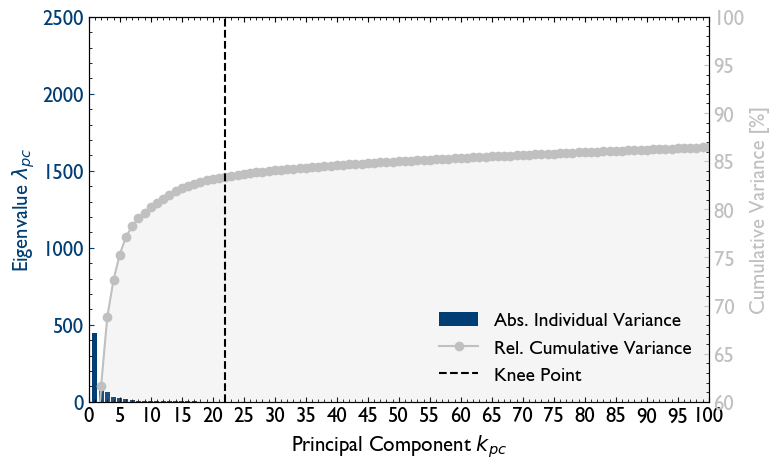

In [6]:
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
silver3 = '#9D9D9D'
gold = '#cfbd62'
gold2 = '#dfc16d' #new but maybe worse


def pca_plotter(eigenvalues,cumulative_variance,knee_criteria,xlim=[-1, 40],ylim=[0,1250],ylim2=[50, 100], face = True,c1='#003E74',c2='#cfbd62', c3 = '#A51C30', sizefont = 16, sizefont2 = 14):
    # Define Font Settings
    plt.rcParams.update({'font.size': sizefont})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Gill Sans'
    # Create subplots 
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    # Plot the scree plot
    bar = ax1.bar(range(len(eigenvalues)), eigenvalues, alpha=1, color = c1,label = 'Abs. Individual Variance')
    ax1.set_xlabel(r'Principal Component $k_{pc}$')
    ax1.set_ylabel(r'Eigenvalue $\lambda_{pc}$')
    # ax1.set_title('Scree Plot')
    ax1.yaxis.label.set_color(c1)
    ax1.tick_params(axis='y', colors=c1)
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_xticks(range(-1,len(eigenvalues),5))
    ax1.set_xticklabels([i+1 for i in range(-1,len(eigenvalues),5)])
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', top=True, right=True)
    # Create a twin y-axis for the cumulative variance plot
    ax2 = ax1.twinx()
    ax2.minorticks_on()
    # Plot the cumulative variance plot
    cum = ax2.plot(cumulative_variance, c=c2, linestyle='-', marker='.', markersize=12,label = 'Relative Cumulative Variance')
    if face:
        ax2.fill_between(range(len(cumulative_variance)),cumulative_variance, color=c2, alpha=0.15)  
    ax2.set_ylabel('Cumulative Variance [%]')
    ax2.yaxis.label.set_color(c2)
    ax2.tick_params(axis='y', colors=c2)
    ax2.set_ylim(ylim2)
    ax2.tick_params(which='both', direction='in', top=True, right=True)
    # Plot Knee
    knee_point = np.argmax(np.diff(cumulative_variance) <= knee_criteria) 
    variance = cumulative_variance[knee_point-1]
    print('Knee Point: ', knee_point)
    print('Variance: ', variance)
    line = plt.axvline(x=knee_point-1, color='black',linestyle = '--',label = 'Knee Point')
    # Combine all labels in one legend
    handles, labels = ax1.get_legend_handles_labels()
    handles += cum
    labels += ['Rel. Cumulative Variance']
    handles += [line]
    labels += ['Knee Point']
    plt.legend(handles=handles, labels=labels, loc='lower right', frameon=False, fontsize = sizefont2)
    plt.show()
    return



# pca_plotter(eigenvalues, cumulative_variance, knee_criteria=0.1, xlim=[-1, 35], ylim=[0, 250],ylim2=[0, 100],face = True)
pca_plotter(eigenvalues, cumulative_variance, knee_criteria=0.1, xlim=[-1, 35], ylim=[0, 2500],ylim2=[60, 100],face = True,c1=imperial,c2=silver2, c3 = '#A51C30', sizefont = 15, sizefont2 = 14)


TSNE Plot

In [19]:
# PCA and TSNE Setting
n_pca = 22 # 15 #21 for ZStandard
n_comp = 2
perp = 50 #200# 90 #80
learn_rate = 120
early_exag = 1
iterations = 1200
random_state = 505 # 27514 # 111 #  27514
init = 'random' #'random'

# Define TSNE Model
tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init=init, random_state=random_state) # rosanne 78592 #lin 27514
# PCA
pca_model = PCA(n_pca)
X_new = pca_model.fit_transform(features)
# Run TSNE Model on Data
tsne_out = tsne_model.fit_transform(X_new)
# tsne_out = tsne_model.fit_transform(features)
print(tsne_out.shape)

# Save TSNE Output
df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
df_tsne['ID'] = list(ids)
df_tsne['obsreg_id'] = list(ids)
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
df_tsne.to_csv(f'{global_path}/tsne/tsne-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}-init{init}-PCA{n_pca}-rs{random_state}.csv', index=False)

(151967, 2)


In [5]:
files = os.listdir(f'{global_path}/tsne/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*hist3D*perp*lr*it*PCA*rs*.csv')] #PCA
tsne_files = [f for f in files if fnmatch.fnmatch(f, '*')] #PCA
# tsne_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*2D*CNN*fc[*neck*xae**TSNE*perp40*lr100*it3000*rs2412.csv')] #AE
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('XAE-ENCODER-3D-FC-fc[1536, 384, 96]-neck24-lr0.001-b1024-reg0.1-…

In [6]:
# Load the DataFrame from the CSV file
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/tsne/{tsne_file}')

flares_maybe = ['10542-331','10556-6687','10556-5752','10556-6687']
dips_maybe = ['13814-586','13813-218','13828-596']

# DIPS ET AL
parmar = ['10783-10-1','10871-10-1','11059-10-1','9070-10-1','9072-10-1'] # LMXB dips!
distefano = ['13814-567-3']
m101ulx = ['4736-81-1','6170-74-1','4733-229-1','4737-74-1','5300-95-1','5322-229-1','6152-81-1']

ieva = ['11272-13','13812-586','13812-218','9550-17','942-101','6152-79']

# FLARES ET AL 
lin = ['4062-31-1', '13454-56-1','20635-58-1'] 
xue = ['957-208', '3389-274','15211-38','15214-29']
irwin = ['3926-13','7800-4','7799-16','8490-30']
glennie = ['12884-10-1']
jonker = ['803-90-1']
vasquez = ['2025-39','9546-17','9548-14','12264-54','15113-59']
vasquez = ['2025-39-1','9548-14-1','15113-59-1']
nandra = ['9875-166', '9456-274', '5849-62']
goulding =['8636-2-1', '8636-3-1'] # last one not listed 2012 2015
NEW = ['23022-122']

flares = ['4395-992-1','16444-1025-1','13637-1078-1','14368-489-1','14368-503-1','10822-185-1','10955-21-1','10996-5-1','2833-53-1','13610-112-1','15214-29-1','1042-24-1']

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez= df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_new = df_tsne.loc[df_tsne['obsreg_id'].isin(NEW)] 

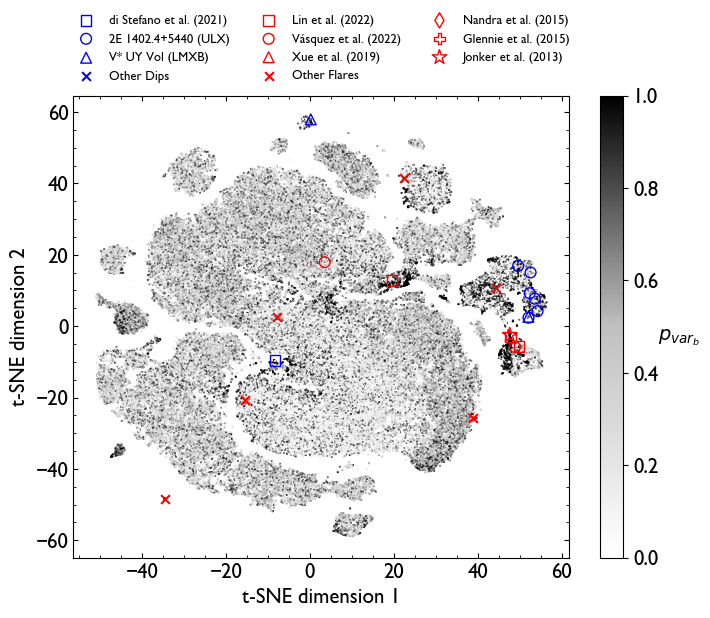

In [11]:
# Plot 3D
import matplotlib.colors as mcolors
# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, axs = plt.subplots(figsize=(8, 6))
# Define the two colors for the colormap
imperial = '#003E74'
imperial2 = '#002147'
imperial3 = "#00ACD7"
darkblue = '#003170'
harvard = '#A51C30'
harvard2 = '#ed1b34'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
gold2 = '#dfc16d'
# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', gold,harvard,'black'], N=256)
cmap_h2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',harvard,'black'], N=256)
cmap_gold = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',gold,'black'], N=256)
cmap_silver = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',silver2,'black'], N=256)
cmap_ic = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',silver2,imperial,'black'], N=256)
cmap_ic2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',imperial,'black'], N=256)
cmap_ic3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [silver2,imperial,'black'], N=256)
# fig.suptitle(tsne_file)
colourmap_var = 'viridis_r'
# colourmap_var = 'magma_r'
# colourmap_var = 'binary'
# colourmap_var = cmap_ic 
colourmap_var = cmap_silver

var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['var_prob_b'], s=0.1, cmap=colourmap_var)
# var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['var_index_b'], s=0.1, cmap=colourmap_var)
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')
# axs.set_title(r'$p_{var_b}$')

sizefont2 = 14
markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Vásquez et al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(tsne_nandra['tsne1'], tsne_nandra['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')
# axs.scatter(tsne_goulding['tsne1'], tsne_goulding['tsne2'], edgecolors=c_f, marker='p', s=markersize*1.5, facecolor='none', label='Goulding et al. (2012)')

# axs.scatter(tsne_irwin['tsne1'], tsne_goulding['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Goulding et al. (2012)')


axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15, fontsize = sizefont2)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, frameon = False,fontsize=9.25)
# axs.legend(loc='upper right', bbox_to_anchor=(1., 1),frameon = False,fontsize=12)
# plt.tight_layout()